In [1]:
import copy
import random
import re

import numpy
import pandas


from hilbert.curves import lib

from curve_fits import Call, Spec

from curve_fits import fits
from curve_fits import frames

In [2]:
def random_ints_sample(size, max_abs=10000):
    return random.sample(range(-max_abs, max_abs), k=size)

In [3]:
size_range = range(1050, 1750)
overfit = 1  # HIGH to differentiate from single-line shape
init_calls = [Call(random_ints_sample(size)) for size in size_range]
profile = frames.TimeComplexityProfile('set', init_calls, {'pop': Call(), 'copy': Call()},
    index=pandas.Index(size_range, name='List length'), overfit=overfit, fraction=0.9, loops=100)

In [4]:
profile.fit_all_with(
    Call(Spec(lib.Polynomial, 2), Spec(lib.Log, 1, pole=10), initial_params=[-1, 1, -1]),
    Call(Spec(lib.Xlog, 1), Spec(lib.InverseXPolynomial, 1)), piecewise=[
        Call([x], *[Call(Spec(lib.Polynomial, 2))]*2) for x in range(1300, 1420)])

In [5]:
profile.best_fits(limit=3)

kind  \
key  cost                                
pop  0.006133  PW:Poly(1)[1365]Poly(1)   
     0.006538  PW:Poly(1)[1364]Poly(1)   
     0.006609  PW:Poly(1)[1366]Poly(1)   
copy 0.010527  PW:Poly(1)[1365]Poly(1)   
     0.011525  PW:Poly(1)[1366]Poly(1)   
     0.011541  PW:Poly(1)[1364]Poly(1)   

                                                             fit DOF  
key  cost                                                             
pop  0.006133  (-0.0089 ± 0.0020) + (0.0000519 ± 0.0000016)x ...   4  
     0.006538  (-0.0093 ± 0.0020) + (0.0000523 ± 0.0000016)x ...   4  
     0.006609  (-0.0109 ± 0.0022) + (0.0000536 ± 0.0000019)x ...   4  
copy 0.010527  (0.0069 ± 0.0026) + (0.0000626 ± 0.0000021)x |...   4  
     0.011525  (0.0044 ± 0.0031) + (0.0000648 ± 0.0000025)x |...   4  
     0.011541  (0.0075 ± 0.0026) + (0.0000621 ± 0.0000021)x |...   4

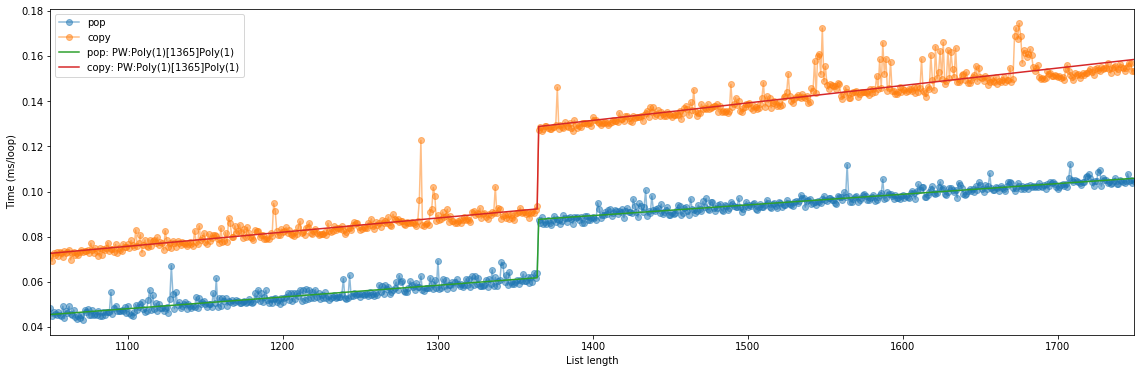

In [6]:
fig, ax = profile.plot(limit=1)

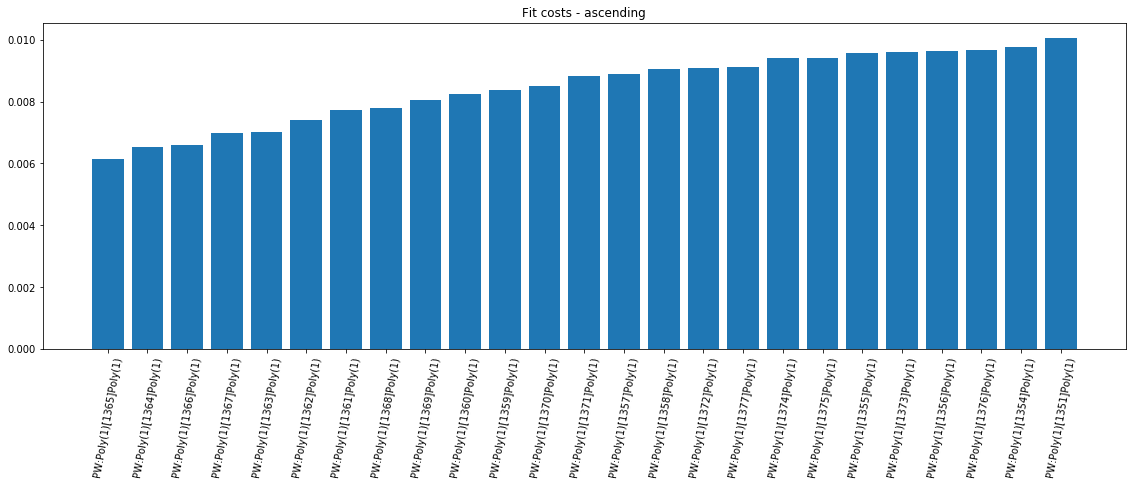

In [7]:
fig, ax = profile.plot_costs('pop', limit=25, rotation=80)

In [8]:
all_fits = profile.best_fits(limit=None)
all_fits[(all_fits.kind == 'Log+Poly(1)') | (all_fits.kind == 'Poly(-1)+Xlog')]

kind  \
key  cost                      
pop  0.018422    Log+Poly(1)   
     0.018696  Poly(-1)+Xlog   
copy 0.026775    Log+Poly(1)   
     0.027134  Poly(-1)+Xlog   

                                                             fit DOF  
key  cost                                                             
pop  0.018422  (-0.97 ± 0.17) + (-0.000002 ± 0.000020)x + (0....   3  
     0.018696      (0.000010266 ± 8.7E-8)xlogx + (-36.7 ± 1.2)/x   2  
copy 0.026775  (-0.68 ± 0.25) + (0.000080 ± 0.000030)x + (0.0...   3  
     0.027134       (0.00001491 ± 1.3E-7)xlogx + (-48.3 ± 1.8)/x   2

In [9]:
pop_fit = profile.best_fit('pop')
pop_fit, pop_fit.curve

(<PiecewiseFit: (-0.0089 ± 0.0020) + (0.0000519 ± 0.0000016)x | (0.0232 ± 0.0015) + (0.00004725 ± 9.6E-7)x>,
 <Vector: (-0.008892141994436487) + (5.185382966517261e-05)x | (0.023237202610424817) + (4.724959515336565e-05)x>)

In [10]:
pop_fit.fits, pop_fit.jumps_at

((<CurveFit: (-0.0089 ± 0.0020) + (0.0000519 ± 0.0000016)x>,
  <CurveFit: (0.0232 ± 0.0015) + (0.00004725 ± 9.6E-7)x>),
 (1365,))

In [11]:
pop_fit.fits[1].measures

(<Measure: 0.0232 ± 0.0015>, <Measure: 0.00004725 ± 9.6E-7>)

In [12]:
pop_fit_copy = copy.deepcopy(pop_fit)
pop_fit_copy.series = None   # Mocked to show equality is not affected
assert pop_fit == copy.deepcopy(pop_fit)

In [14]:
pop_fit_call = Call(pop_fit.jumps_at, *[Call(Spec(lib.Polynomial, 2))]*2)
assert pop_fit != fits.PiecewiseFit(profile.data['pop'], pop_fit.space, *pop_fit_call.args, **pop_fit_call.kwargs)

In [15]:
assert [re.sub(r'\[[0-9]{3,}\]', '', kind) for kind in profile.best_fits(limit=1)['kind']] == [
    'PW:Poly(1)Poly(1)', 'PW:Poly(1)Poly(1)']